In [24]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LogisticRegression
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings
warnings.filterwarnings('ignore')

In [62]:
df = pd.read_csv("BreastCancer.csv", index_col=  0)
df

,Clump,UniCell_Size,Uni_CellShape,MargAdh,SEpith,BareN,BChromatin,NoemN,Mitoses,Class
Code,,,,,,,,,,
61634,5,4,3,1,2,2,2,3,1,Benign
63375,9,1,2,6,4,10,7,7,2,Malignant
76389,10,4,7,2,2,8,6,1,1,Malignant
95719,6,10,10,10,8,10,7,10,7,Malignant
128059,1,1,1,1,2,5,5,1,1,Benign
...,...,...,...,...,...,...,...,...,...,...
1369821,10,10,10,10,5,10,10,10,7,Malignant
1371026,5,10,10,10,4,10,5,6,3,Malignant
1371920,5,1,1,1,2,1,3,2,1,Benign


In [72]:
x, y = df.drop("Class", axis = 'columns'), df["Class"]

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    random_state = 24,
                                                    test_size = 0.3,
                                                    stratify = y)

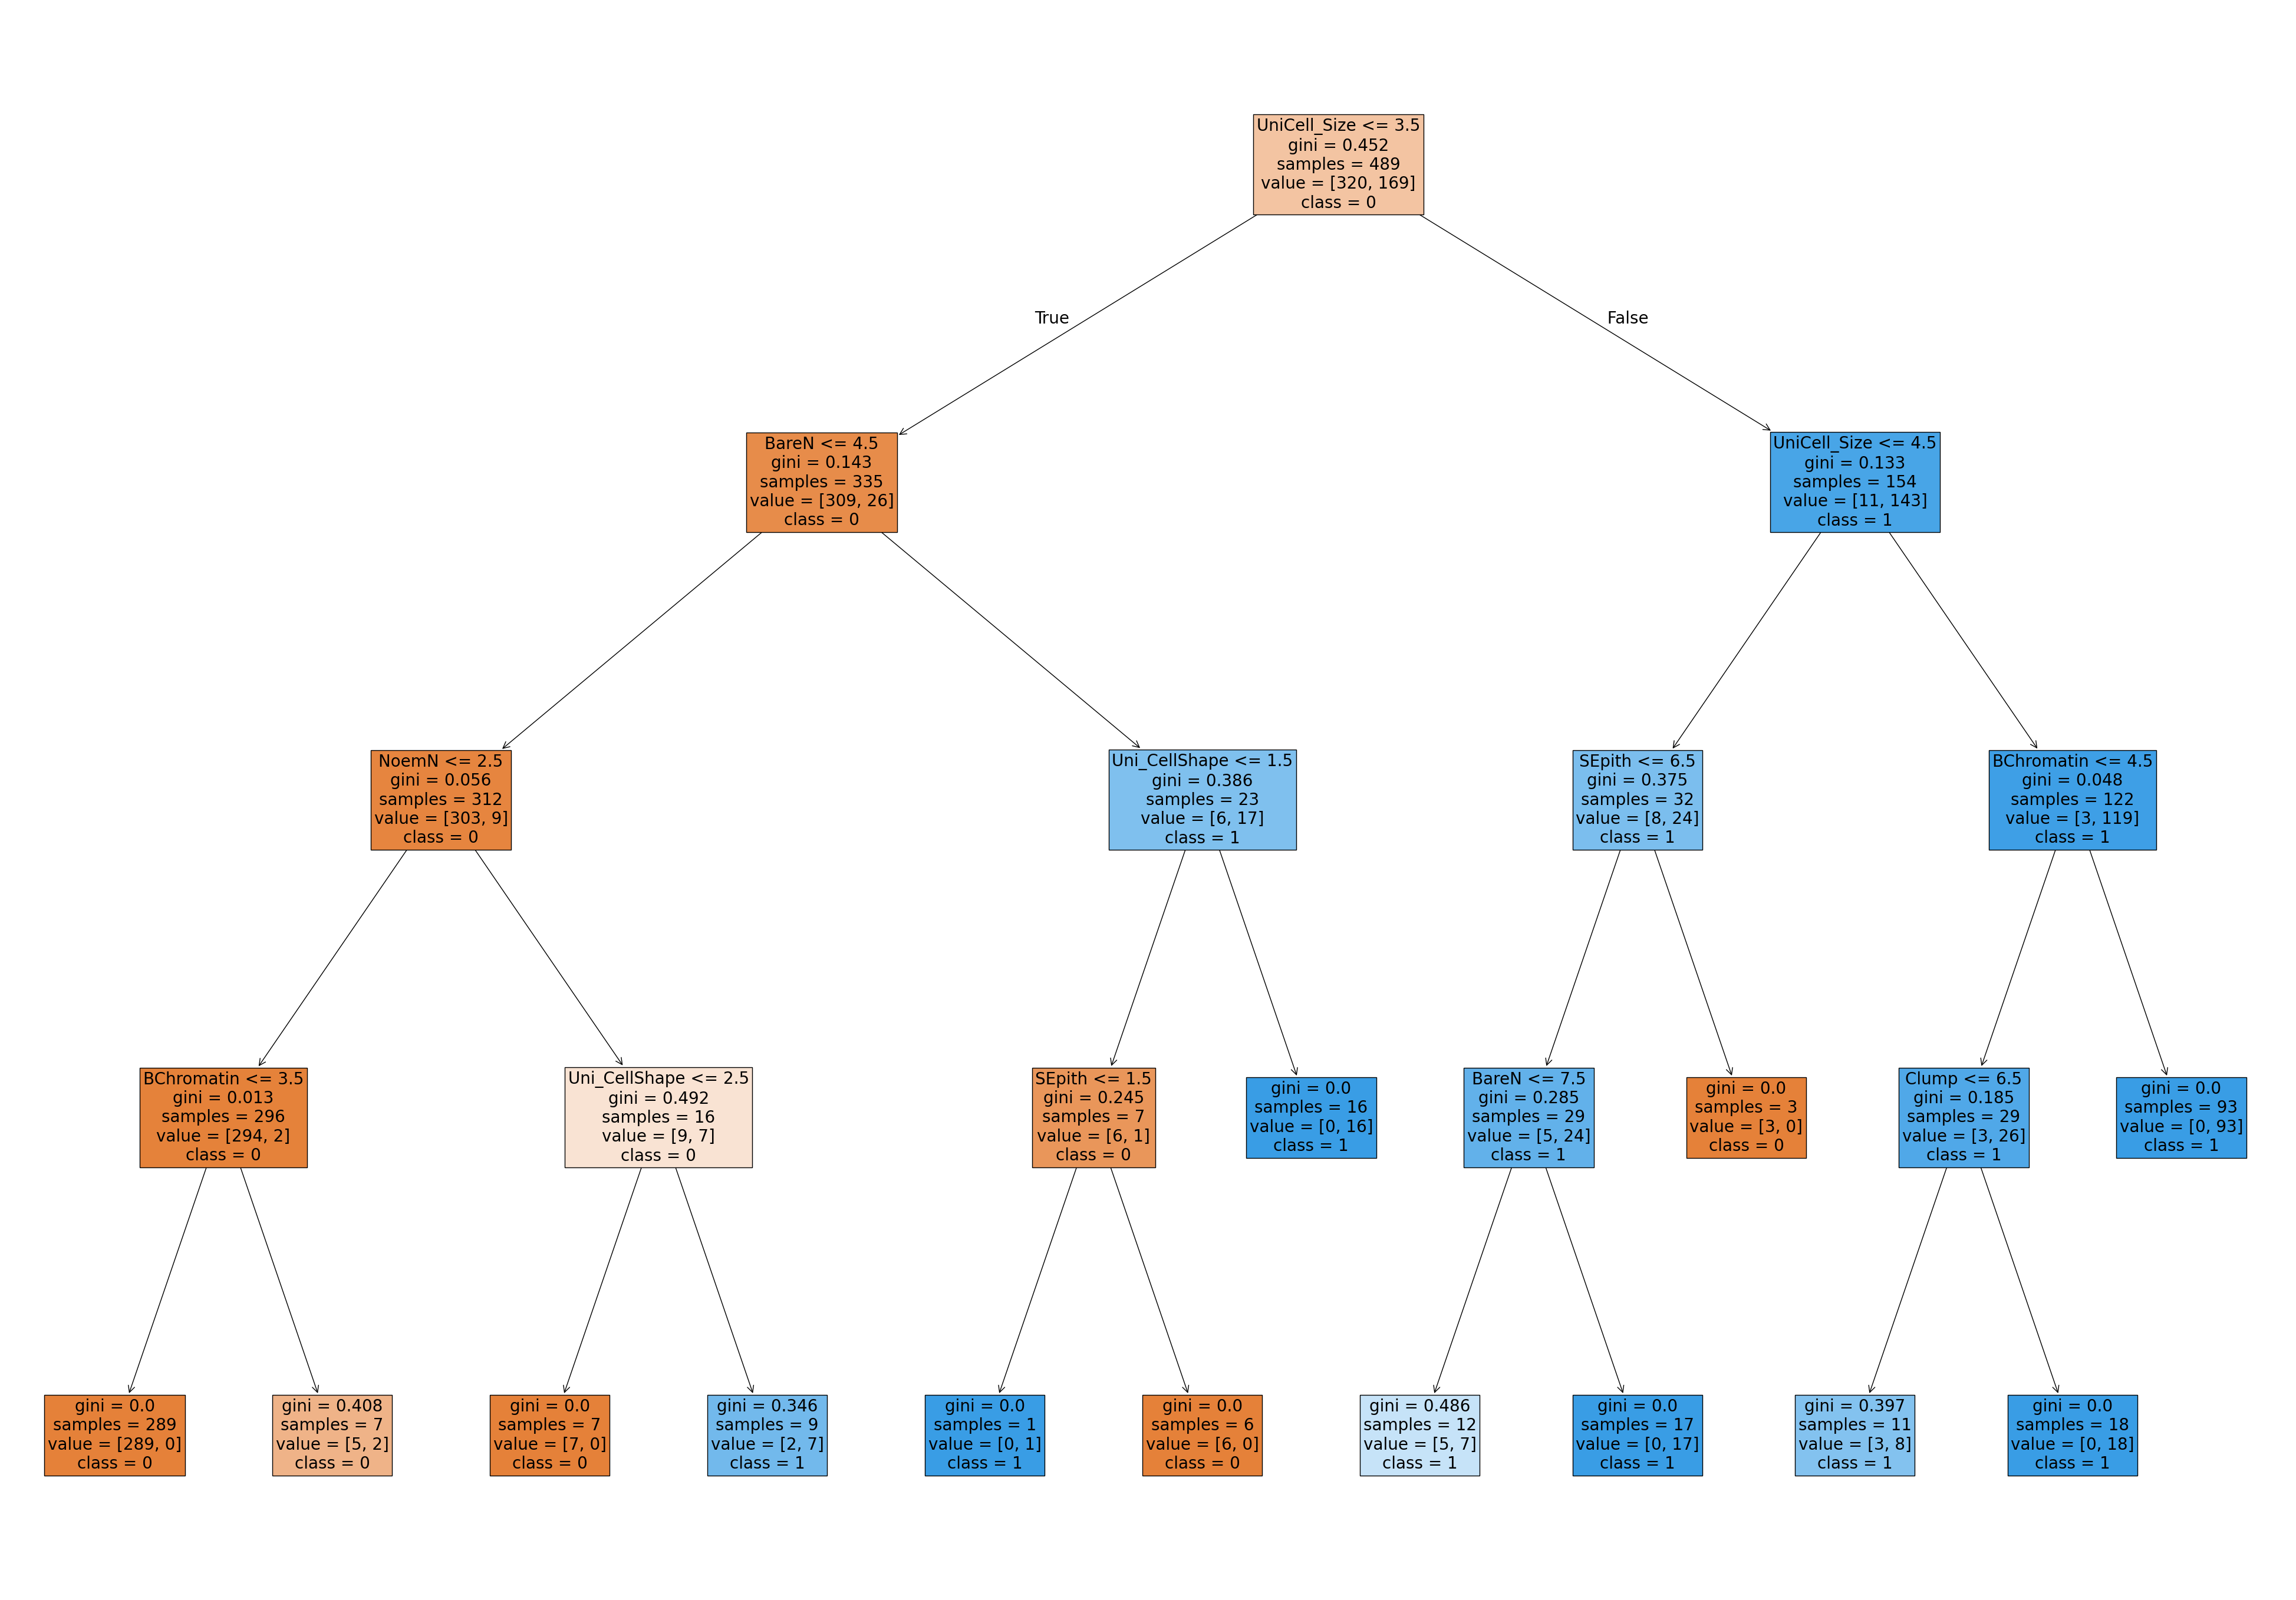

In [68]:
dtc = DecisionTreeClassifier(
    random_state = 24,
    max_depth = 4
)

dtc.fit(x_train, y_train)

plt.figure(figsize = (50, 35))
plot_tree(dtc, 
          feature_names = list(x.columns), 
          class_names = ["0", "1"],
          filled = True, 
          fontsize = 20,
         )

plt.show()

In [70]:
y_pred = dtc.predict(x_test)
accuracy_score(y_test, y_pred)

0.9571428571428572

In [98]:
# ______________________________________________________________________________________
# Pipeline

# one hot encoder
ohe = OneHotEncoder(
    handle_unknown="ignore", 
    sparse_output=False, 
    drop='first'
).set_output(transform='pandas')

trans_ohe = make_column_transformer(
    ('passthrough', make_column_selector(dtype_exclude=object)),
    (ohe, make_column_selector(dtype_include=object)),
    verbose_feature_names_out=False
).set_output(transform='pandas')


# scaler
scl_std = StandardScaler().set_output(transform = "pandas")
scl_mm = MinMaxScaler().set_output(transform = "pandas")


# model
dtc = DecisionTreeClassifier(
    random_state = 24,
    # max_depth = 4
)


pipe_pca = Pipeline([("SCL", scl_std), ("DTC", dtc)])


# _____________________________________________________________________________________
# GCV

params = {
    "DTC__max_depth" : list(range(1, 7)),
}

kfolds = StratifiedKFold(n_splits = 5, 
                        random_state = 24, 
                        shuffle = True)

gcv = GridSearchCV(pipe_pca,
                  param_grid = params,
                  scoring = "accuracy",
                  # cv = kfolds,
                  verbose = 3)

gcv.fit(x, y)
# gcv.fit(x, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..................DTC__max_depth=1;, score=0.921 total time=   0.0s
[CV 2/5] END ..................DTC__max_depth=1;, score=0.857 total time=   0.0s
[CV 3/5] END ..................DTC__max_depth=1;, score=0.893 total time=   0.0s
[CV 4/5] END ..................DTC__max_depth=1;, score=0.907 total time=   0.0s
[CV 5/5] END ..................DTC__max_depth=1;, score=0.942 total time=   0.0s
[CV 1/5] END ..................DTC__max_depth=2;, score=0.936 total time=   0.0s
[CV 2/5] END ..................DTC__max_depth=2;, score=0.914 total time=   0.0s
[CV 3/5] END ..................DTC__max_depth=2;, score=0.936 total time=   0.0s
[CV 4/5] END ..................DTC__max_depth=2;, score=0.957 total time=   0.0s
[CV 5/5] END ..................DTC__max_depth=2;, score=0.899 total time=   0.0s
[CV 1/5] END ..................DTC__max_depth=3;, score=0.914 total time=   0.0s
[CV 2/5] END ..................DTC__max_depth=3;,

GridSearchCV(estimator=Pipeline(steps=[('SCL', StandardScaler()),
                                       ('DTC',
                                        DecisionTreeClassifier(random_state=24))]),
             param_grid={'DTC__max_depth': [1, 2, 3, 4, 5, 6]},
             scoring='accuracy', verbose=3)

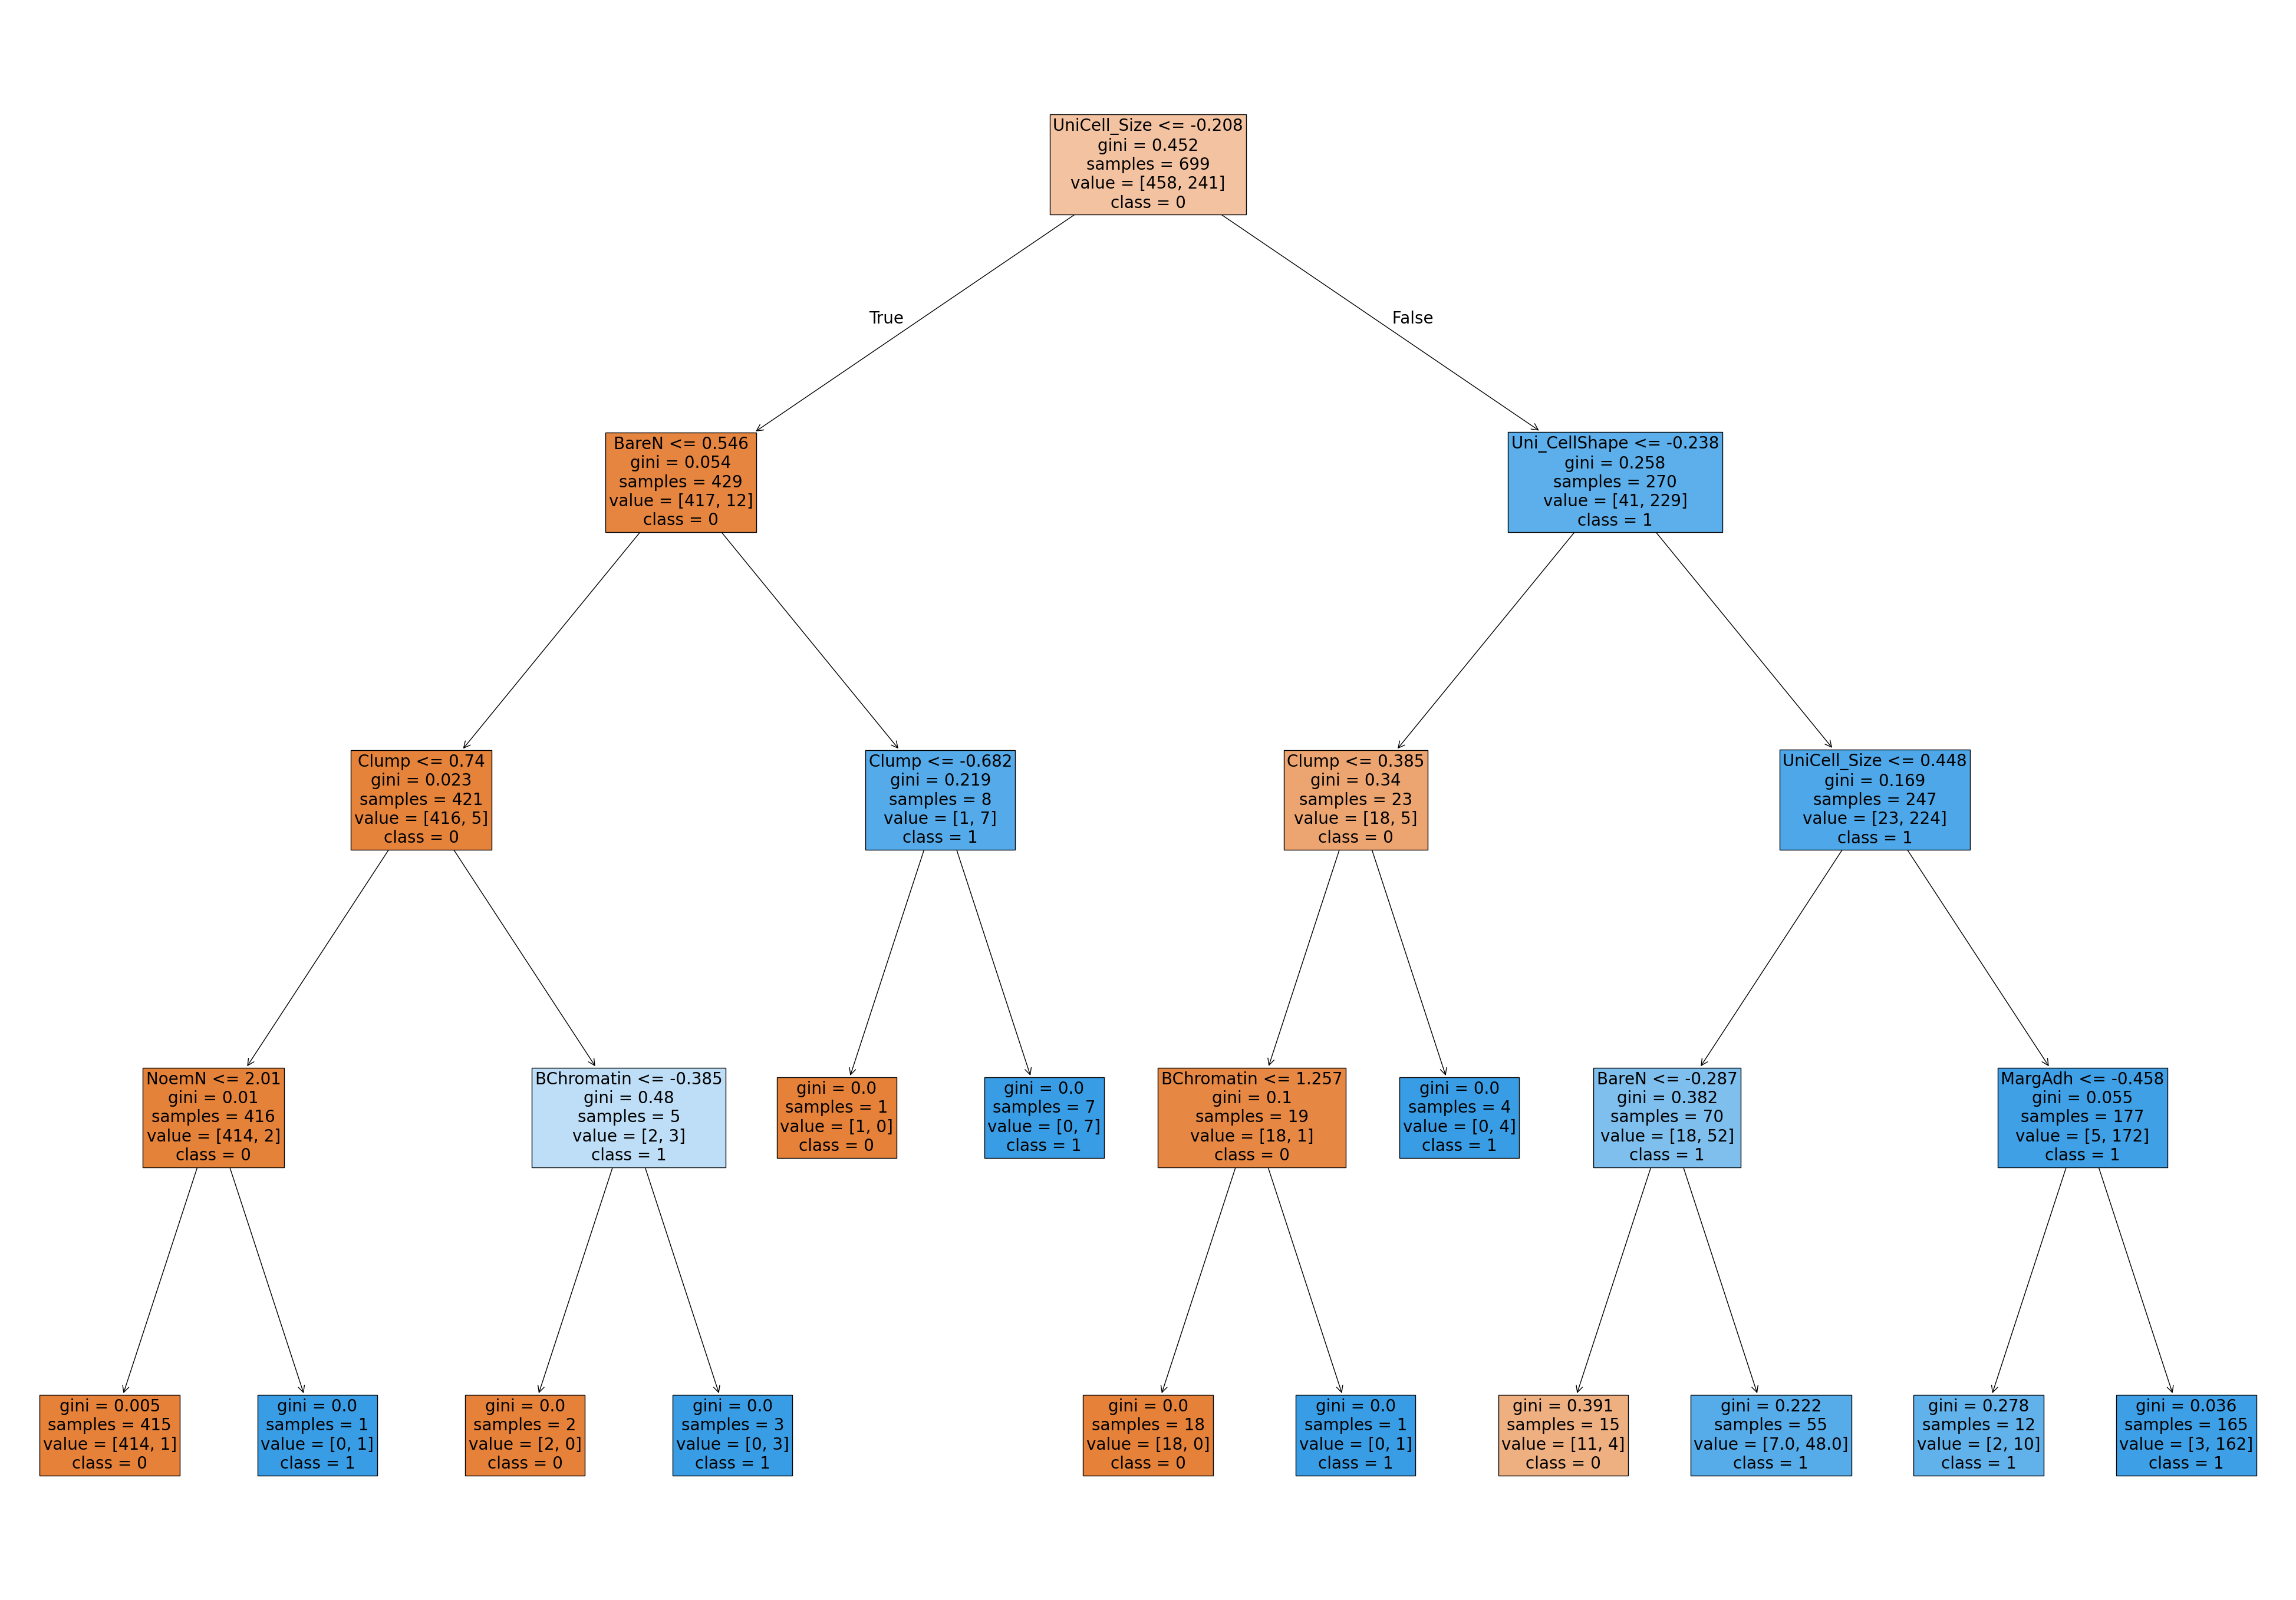

In [104]:
best_tree = gcv.best_estimator_[1]
plt.figure(figsize = (50, 35))
plot_tree(best_tree, 
          feature_names = list(x.columns), 
          class_names = ["0", "1"],
          filled = True, 
          fontsize = 20,
         )

plt.show()

In [102]:
print(gcv.best_estimator_)

Pipeline(steps=[('SCL', StandardScaler()),
                ('DTC', DecisionTreeClassifier(max_depth=4, random_state=24))])


In [106]:
y_pred = gcv.predict(x_test)
accuracy_score(y_test, y_pred)

0.9761904761904762

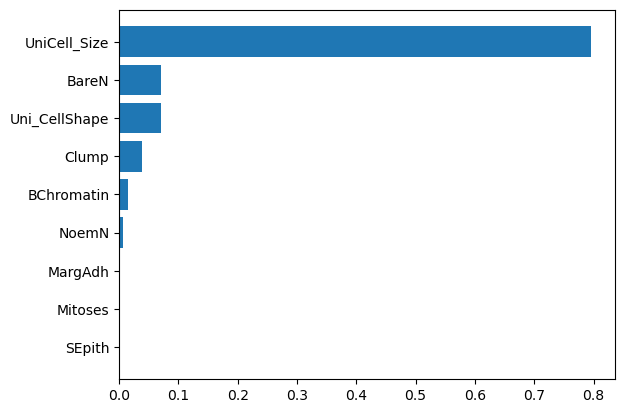

In [132]:
df_imp  = pd.DataFrame({"feature" : list(x.columns), 
                        "importance" : best_tree.feature_importances_})
df_imp.sort_values("importance", inplace = True, )
plt.barh(df_imp["feature"], df_imp["importance"])
plt.show()
# print(df_imp)